## Compare two naive solutions
### dataset
- 20180816

### algo
#### univmon
- cardinality
- entropy
- ARE

#### hll
- cardinality

#### CM
- ARE
- entropy

#### CS
- ARE

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import json

---

## Define common functions

In [ ]:
## read_data from result of control plane
def read_data(algos, row=4, width=1024, level=1, seed=1, count=1, flowkey='dstIP,dstPort', 
              epochs=['10', '20', '30'], dataset='equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/'):
    res = {}
    for algo in algos:
        res[algo] = []
        for epoch in epochs:
            path = f"../../result_cp/QuerySketch/{algo}/{dataset}"\
                    f"{flowkey}/row_{row}_width_{width}_level_{level}_epoch_{epoch}_count_{count}_seed_{seed}/data.pkl"
            # print(algo, epoch)
            with open(path, 'rb') as f:
                ll = pickle.load(f)
            res[algo].append(ll)
            # print(ll[0])
    return res

In [ ]:
## Define metric -> algos
def get_metrics():
    metrics = {}
    metrics['hh'] = ['cm', 'cs']
    metrics['card'] = ['hll']
    metrics['entropy'] = ['cm']
    return metrics
metrics = get_metrics()
general_metrics = ['univmon']

In [ ]:
## Define mapping dictionary for index <---> metric
algos = ['univmon', 'cm', 'cs', 'hll', 'lc', 'mrac', 'll', 'mrb']
def get_metric_mapping(algos = ['univmon', 'cm', 'cs', 'hll']):
    mapping = {}
    for k in algos:
        mapping[k] = {}

    if 'univmon' in algos:
        # UNIV: [true_entropy, sim_entropy, sim_entropy_error, true_card, sim_card, sim_card_error, ARE]
        mapping['univmon']['hh'] = 6
        mapping['univmon']['card'] = 5 
        mapping['univmon']['entropy'] = 2
    if 'cm' in algos:
        # cm: [entropy, entropy_est, relative_entropy_error, sim_ARE_error, sim_change_detection_error]
        mapping['cm']['hh'] = 3
        mapping['cm']['entropy'] = 2
        mapping['cm']['change_det'] = 4
    if 'cs' in algos:
        # cs: [entropy, entropy_est, relative_entropy_error, sim_ARE_error, sim_change_detection_error]
        mapping['cs']['hh'] = 3
        mapping['cs']['entropy'] = 2
        mapping['cs']['change_det'] = 4
    if 'hll' in algos:
        # hll: [true_cardinality, sim_cardinality, sim_error]
        mapping['hll']['card'] = 2
    if 'll' in algos:
        # ll: [true_cardinality, sim_cardinality, sim_error]
        mapping['ll']['card'] = 2
    if 'lc' in algos:
        # lc: [true_cardinality, sim_cardinality, sim_error]
        mapping['lc']['card'] = 2
    if 'mrac' in algos:
        # mrac: [WMRD, entropy_true, entropy_est, entropy_err]
        mapping['mrac']['fsd'] = 0
        mapping['mrac']['entropy'] = 3
    if 'mrb' in algos:
        # mrb: [true_cardinality, sim_cardinality, sim_error]
        mapping['mrb']['card'] = 2
    return mapping
mapping = get_metric_mapping(algos)

---

## Compare two naive solutions
### Best algo per metric

In [27]:
## temporary function
def call_read_data_per_algo(flowkey='dstIP,dstPort', epochs=['30']):
    seed = 1
    count = 1
    result = {}

    algos = ['univmon']
    r = 4
    w = 1024
    level = 16
    tmp = read_data(algos, r, w, level, seed, count, flowkey, epochs)
    result = {**result, **tmp}

    algos = ['cm', 'cs']
    r = 4
    w = 16384
    level = 1
    tmp = read_data(algos, r, w, level, seed, count, flowkey, epochs)
    result = {**result, **tmp}

    algos = ['hll']
    r = 1
    w = 16384
    seed = 3
    level = 1
    tmp = read_data(algos, r, w, level, seed, count, flowkey, epochs)
    result = {**result, **tmp}
    return result
# call_read_data_per_algo()

In [28]:
metrics = get_metrics()
general_metrics = ['univmon']

In [29]:
epochs = ['30']
flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]

In [30]:
algos = ['univmon', 'cm', 'cs', 'hll']
# algos = ['univmon', 'cm', 'cs', 'hll', 'lc', 'mrac', 'll', 'mrb']
mapping = get_metric_mapping(algos)

In [31]:
VERBOSE = False
times = 40

# key of result: metric
result_algo = {}
result_val = {}
for k in metrics:
    result_algo[k] = []
    result_val[k] = []

for t in range(times):
    epoch = random.randint(0, len(epochs)-1)
    flowkey = random.randint(0, len(flowkeys)-1)
    if VERBOSE:
        print('epoch:', epochs[epoch])
        print('flowkey:', flowkeys[flowkey])
    
    data = call_read_data_per_algo(flowkeys[flowkey], epochs)
    
    for metric, algos in metrics.items():
        tmp_algo = ''
        tmp_min = 100
        for algo in (algos + general_metrics):
            if VERBOSE:
                print(metric, algo)
            ll = []
            for d in data[algo][epoch]:
                ll.append(d[mapping[algo][metric]])
            if np.median(ll) < tmp_min:
                tmp_min = np.median(ll)
                tmp_algo = algo
        result_algo[metric].append(tmp_algo)
        result_val[metric].append(tmp_min)

In [32]:
# key: algo, index of epoch, a list for all result from control plane, metric mapping of algo
data['cs'][0][0]

[13.318970399101207,
 11.75896521403131,
 11.7126559961059,
 0.8838254978979816,
 0.8838254978979816]

In [33]:
# index 0 is best algo, 1 is general algo
global_result_val = [None] * 2
global_result_val[0] = result_val
print(result_algo)
# print(result_val)

{'hh': ['cm', 'cs', 'cm', 'cm', 'cm', 'cs', 'cs', 'cs', 'cs', 'cs', 'cm', 'cs', 'cs', 'cm', 'cs', 'cm', 'cs', 'cs', 'cm', 'cm', 'cs', 'cs', 'cm', 'cm', 'cm', 'cm', 'cm', 'cs', 'cs', 'cs', 'cm', 'cs', 'cm', 'cm', 'cm', 'cm', 'cs', 'cm', 'cm', 'cm'], 'card': ['hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll', 'hll'], 'entropy': ['univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon', 'univmon']}


In [34]:
print("number of algos in metrics")
# foreach metric in result
for k in result_algo:
    print("\nmetric:", k)
    # foreach algo in a metric
    for algo in (metrics[k] + general_metrics):
        print(algo, result_algo[k].count(algo))

number of algos in metrics

metric: hh
cm 22
cs 18
univmon 0

metric: card
hll 40
univmon 0

metric: entropy
cm 0
univmon 40


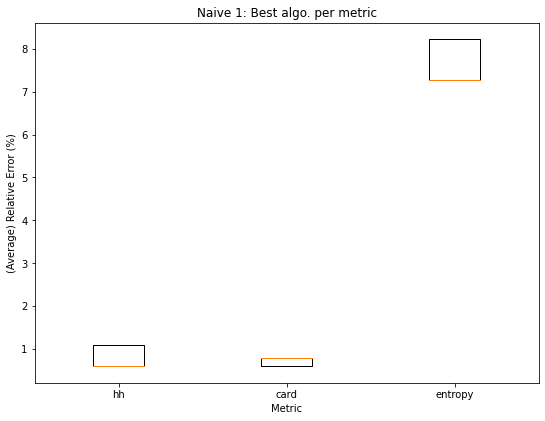

In [37]:
# box plot 
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/

plot_list = []
xlabels = []
for k in result_val:
    plot_list.append(result_val[k])
    xlabels.append(k)

fig = plt.figure(figsize = (7, 5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(plot_list)

ax.set_xticklabels(xlabels)
plt.title("Naive 1: Best algo. per metric")
plt.ylabel("(Average) Relative Error (%)")
plt.xlabel("Metric")
# show plot
plt.show()

### Most general as possible (an algo do every metric)

In [13]:
## temporary function
def call_read_data_general_algo(flowkey='dstIP,dstPort'):
    result = {}

    algos = ['univmon']
    r = 4
    w = 2048
    tmp = read_data(algos, r, w, flowkey)
    result = {**result, **tmp}
    return result

In [14]:
VERBOSE = False
times = 20

result_algo = {}
result_val = {}
for k in metrics:
    result_algo[k] = []
    result_val[k] = []

for t in range(times):
    epoch = random.randint(0, len(epochs)-1)
    flowkey = random.randint(0, len(flowkeys)-1)
    if VERBOSE:
        print('epoch:', epochs[epoch])
        print('flowkey:', flowkeys[flowkey])
    
    data = call_read_data_general_algo(flowkeys[flowkey])
    
    for metric, algos in metrics.items():
        tmp_algo = ''
        tmp_min = 100
        for algo in general_metrics:
            if VERBOSE:
                print(metric, algo)
            ll = []
            for d in data[algo][epoch]:
                ll.append(d[mapping[algo][metric]])
            if np.median(ll) < tmp_min:
                tmp_min = np.median(ll)
                tmp_algo = algo
        result_algo[metric].append(tmp_algo)
        result_val[metric].append(tmp_min)

In [15]:
global_result_val[1] = result_val
# print(result_algo)
print(result_val)

{'hh': [1.6848814763411863, 1.3092427334926557, 1.2377577974665437, 1.6846812676166092, 1.1050076080153377, 1.6285944297210655, 1.2377577974665437, 1.2560325813294801, 1.6846812676166092, 1.3092427334926557, 1.2560325813294801, 1.6848814763411863, 0.9977634880133939, 1.4262237659888177, 1.6846812676166092, 1.2560325813294801, 1.6846812676166092, 1.3092427334926557, 1.450846994463833, 1.2560325813294801], 'card': [28.032127578447167, 4.8388407942441685, 17.477412097681338, 16.61785101281151, 9.921576741827147, 15.555940394150664, 17.477412097681338, 7.4823473072261075, 16.61785101281151, 4.8388407942441685, 7.4823473072261075, 28.032127578447167, 6.344444104976933, 11.065948897748957, 16.61785101281151, 7.4823473072261075, 16.61785101281151, 4.8388407942441685, 7.462154895073621, 7.4823473072261075], 'entropy': [1.439309617009481, 1.8924758053698527, 0.6750987417799937, 2.5796468048306043, 1.727016122456436, 0.928294889753086, 0.6750987417799937, 1.6823539162819576, 2.5796468048306043, 

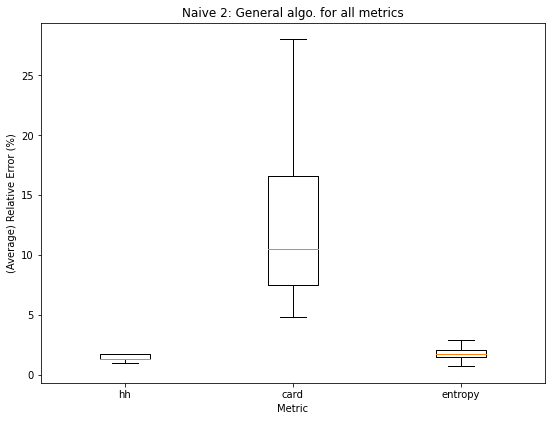

In [16]:
# box plot 
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/

plot_list = []
xlabels = []
for k in result_val:
    plot_list.append(result_val[k])
    xlabels.append(k)

fig = plt.figure(figsize = (7, 5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(plot_list)

ax.set_xticklabels(xlabels)
plt.title("Naive 2: General algo. for all metrics")
plt.ylabel("(Average) Relative Error (%)")
plt.xlabel("Metric")
# show plot
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


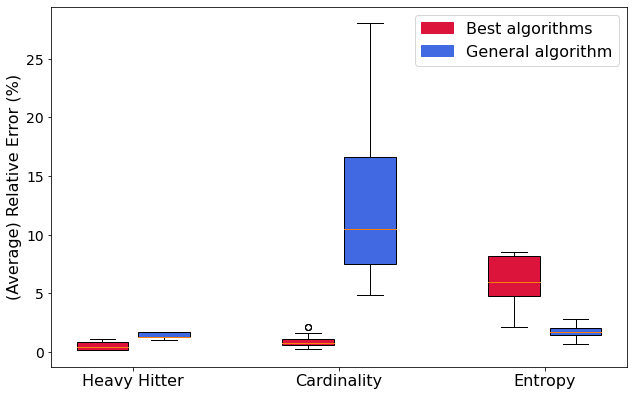

In [185]:
## comparison version plot
# box plot 
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# Box plots with custom fill colors
# https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

import matplotlib.patches as mpatches

xlabels = ['Heavy Hitter', "Cardinality", "Entropy"]
colors = ['crimson', 'royalblue']
colors = colors * len(global_result_val[0])

fig = plt.figure(figsize = (8, 5))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

plot_list = []
for k in global_result_val[0]:
    plot_list.append(global_result_val[0][k])
    plot_list.append(global_result_val[1][k])

# Creating plot
bplot = ax.boxplot(x=plot_list, 
                   positions = [1.2,1.8, 3.2,3.8, 5.2,5.8],
                   patch_artist=True)
# ax.set_xlim(0, 1)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# plt.title("Naive solutions comparison", fontsize=16)
plt.ylabel("(Average) Relative Error (%)", fontsize=16)
# plt.xlabel("Solution")
plt.xticks([1.5, 3.5, 5.5], xlabels, fontsize=16)
plt.yticks(fontsize=14)

# create legends
# xlabels = ['Best algorithms', "General algorithm"]
legend_patch = []
legend_patch.append(mpatches.Patch(color='crimson', label='Best algorithms'))
legend_patch.append(mpatches.Patch(color='royalblue', label='General algorithm'))
plt.legend(handles=legend_patch, fontsize=16)

# plt.savefig('naive_solution_comparison.png', format='png', bbox_inches='tight')
# plt.savefig('naive_solution_comparison.eps', format='eps', bbox_inches='tight')

# show plot
plt.show()

In [164]:
np.random.normal(0.1, 0.05, size=40)

array([0.1216132 , 0.04254982, 0.13659472, 0.02933182, 0.11275453,
       0.08709187, 0.138198  , 0.11194447, 0.03420026, 0.07647778,
       0.04463837, 0.09437868, 0.07779481, 0.03543468, 0.11883769,
       0.12034881, 0.14153182, 0.10260142, 0.12733588, 0.12692565,
       0.09419536, 0.05906843, 0.15747818, 0.10937669, 0.07826018,
       0.19620454, 0.08872757, 0.15464232, 0.17253338, 0.13806216,
       0.13323353, 0.13052287, 0.10640285, 0.17179477, 0.0944194 ,
       0.06336332, 0.10068148, 0.06941075, 0.1517553 , 0.1275969 ])

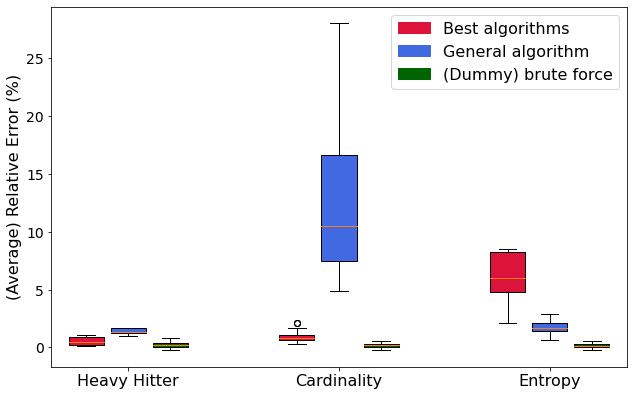

In [184]:
## comparison version plot
# box plot 
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# Box plots with custom fill colors
# https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

import matplotlib.patches as mpatches

xlabels = ['Heavy Hitter', "Cardinality", "Entropy"]
colors = ['crimson', 'royalblue', 'darkgreen']
colors = colors * len(global_result_val[0])

fig = plt.figure(figsize = (8, 5))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

plot_list = []
for k in global_result_val[0]:
    plot_list.append(global_result_val[0][k])
    plot_list.append(global_result_val[1][k])
    plot_list.append(np.random.normal(0.2, 0.2, size=40))

# Creating plot
bplot = ax.boxplot(x=plot_list, 
                   positions = [1.2,1.8,2.4, 4.2,4.8,5.4, 7.2,7.8,8.4],
                   patch_artist=True)
# ax.set_xlim(0, 1)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# plt.title("Naive solutions comparison", fontsize=16)
plt.ylabel("(Average) Relative Error (%)", fontsize=16)
# plt.xlabel("Solution")
plt.xticks([1.8, 4.8, 7.8], xlabels, fontsize=16)
plt.yticks(fontsize=14)

# create legends
# xlabels = ['Best algorithms', "General algorithm"]
legend_patch = []
legend_patch.append(mpatches.Patch(color='crimson', label='Best algorithms'))
legend_patch.append(mpatches.Patch(color='royalblue', label='General algorithm'))
legend_patch.append(mpatches.Patch(color='darkgreen', label='(Dummy) brute force'))
plt.legend(handles=legend_patch, fontsize=16)

# plt.savefig('test.png', format='png', bbox_inches='tight')
# plt.savefig('test.eps', format='eps', bbox_inches='tight')

# show plot
plt.show()

---

## Figure 7

In [5]:
def get_result_from_pkl(algos = ['cm'], rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072], level=1, seed=1, 
                           count=1, measure_list = ['hh', 'entropy'], flowkeys = ["srcIP,srcPort", "dstIP,dstPort",], epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/']):
    # key: metric, row, width
    ret = {}
    for m in measure_list:
        ret[m] = {}
        for r in rows:
            ret[m][r] = {}
            for w in widths:
                ret[m][r][w] = []

    for r in rows:
        for w in widths:
            for flowkey in flowkeys:
                for dataset in datasets:
                    tmp = read_data(algos, r, w, level, seed, count, flowkey, epochs, dataset)
                    for algo in algos:
                        for measure in measure_list:
                            # epoch
                            for e in range(len(epochs)):
                                # ll = []
                                # raw data
                                for d in tmp[algo][e]:
                                    # ll.append(d[mapping[algo][measure]])
                                    ret[measure][r][w].append(d[mapping[algo][measure]])
                                # print(w, flowkey, measure, epochs[e], np.mean(ll))
    return ret

#### Common variables

In [6]:
seed = 1
count = 1
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
flowkeys = ["dstIP,dstPort",]
epochs = ['30']
datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]

#### Strawman 1

In [7]:
all_metrics = []

## key: metric
ret_sol1 = {}

#########################################
measure_list = ['card']
algos = ['hll']
rows = [1]
widths = [8192]
level = 1

all_metrics += measure_list
ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol1 = {**ret_sol1, **tmp}

#########################################
measure_list = ['hh', 'change_det']
algos = ['cs']
rows = [5]
widths = [16384]
level = 1

all_metrics += measure_list
ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol1 = {**ret_sol1, **tmp}

#########################################
measure_list = ['entropy']
algos = ['mrac']
rows = [1]
widths = [8192]
level = 8

all_metrics += measure_list
ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol1 = {**ret_sol1, **tmp}

# ret_sol1

#### Strawman 2

In [8]:
## key: metric
ret_sol2 = {}

#########################################
measure_list = ['card']
algos = ['hll']
rows = [1]
widths = [4096]
level = 1

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol2 = {**ret_sol2, **tmp}

#########################################
measure_list = ['hh', 'change_det']
algos = ['cs']
rows = [5]
widths = [16384]
level = 1

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol2 = {**ret_sol2, **tmp}

#########################################
measure_list = ['entropy']
algos = ['mrac']
rows = [1]
widths = [8192]
level = 8

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol2 = {**ret_sol2, **tmp}

# ret_sol2

#### Strawman 3

In [9]:
## key: metric
ret_sol3 = {}

#########################################
measure_list = ['card']
algos = ['hll']
rows = [1]
widths = [4096]
level = 1

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol3 = {**ret_sol3, **tmp}

#########################################
measure_list = ['hh', 'change_det']
algos = ['cs']
rows = [5]
widths = [16384]
level = 1

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol3 = {**ret_sol3, **tmp}

#########################################
measure_list = ['entropy']
algos = ['mrac']
rows = [1]
widths = [8192]
level = 8

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_sol3 = {**ret_sol3, **tmp}

# ret_sol3

#### US solution

In [10]:
## key: metric
ret_us = {}

#########################################
measure_list = ['card']
algos = ['hll']
rows = [1]
widths = [16384]
level = 1

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_us = {**ret_us, **tmp}

#########################################
measure_list = ['hh', 'change_det']
algos = ['cs']
rows = [5]
widths = [32768]
level = 1

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_us = {**ret_us, **tmp}

#########################################
measure_list = ['entropy']
algos = ['mrac']
rows = [1]
widths = [16384]
level = 8

ret = get_result_from_pkl(algos, rows, widths, level, seed, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
    tmp = {}
    tmp[m] = ret[m][rows[0]][widths[0]]
    ret_us = {**ret_us, **tmp}

# ret_us

In [11]:
## ret_us['card']
## key: metric
# ret_us

### Ploting function

In [12]:
def get_x_position(num_metric=3, num_solution=4):
    ll = []
    for i in range(num_metric):
        padding = i * num_solution + 1
        val = -0.4
        for j in range(num_solution):
            val += 0.6
            ll.append(padding + val)
    return ll
def get_xtick_position(num_metric=3, num_solution=4):
    isOdd = 0
    if num_solution % 2 == 1:
        isOdd = 0.4
    total = num_metric * num_solution
    ll = []
    for i in range(num_metric):
        padding = i * num_solution
        val = num_solution/2
        ll.append(padding + val + isOdd)
    return ll
# get_x_position()
# get_xtick_position()

### Raw results

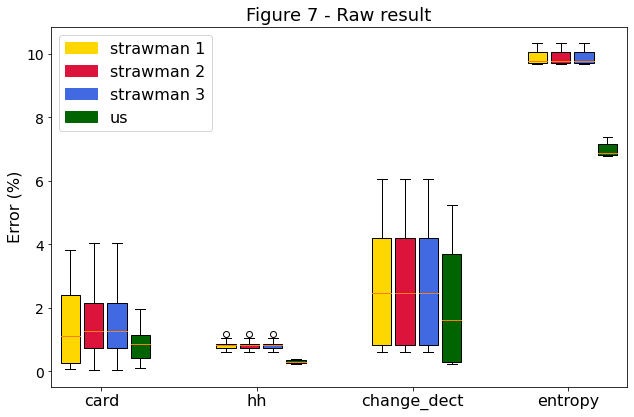

In [13]:
## comparison version plot
# box plot 
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# Box plots with custom fill colors
# https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

import matplotlib.patches as mpatches

# xlabels = ['Heavy Hitter', "Cardinality", "Entropy"]
xlabels = all_metrics
colors = ['gold', 'crimson', 'royalblue', 'darkgreen']
colors = colors * len(xlabels)

fig = plt.figure(figsize = (8, 5))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

plot_list = []
for m in all_metrics:
    plot_list.append(ret_sol1[m])
    plot_list.append(ret_sol2[m])
    plot_list.append(ret_sol3[m])
    plot_list.append(ret_us[m])

# Creating plot
bplot = ax.boxplot(x=plot_list, 
                   positions = get_x_position(len(all_metrics), 4),
                   patch_artist=True)
# ax.set_xlim(0, 1)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# plt.title("Naive solutions comparison", fontsize=16)
plt.ylabel("Error (%)", fontsize=16)
# plt.xlabel("Solution")
plt.xticks(get_xtick_position(len(all_metrics), 4), xlabels, fontsize=16)
plt.yticks(fontsize=14)

plt.title("Figure 7 - Raw result", fontsize=18)

# create legends
# xlabels = ['Best algorithms', "General algorithm"]
legend_patch = []
legend_patch.append(mpatches.Patch(color='gold', label='strawman 1'))
legend_patch.append(mpatches.Patch(color='crimson', label='strawman 2'))
legend_patch.append(mpatches.Patch(color='royalblue', label='strawman 3'))
legend_patch.append(mpatches.Patch(color='darkgreen', label='us'))
plt.legend(handles=legend_patch, fontsize=16)

# plt.savefig('test.png', format='png', bbox_inches='tight')
# plt.savefig('test.eps', format='eps', bbox_inches='tight')

# show plot
plt.show()

### Gain over strawman

In [23]:
gain_result = {}

for m in all_metrics:
    gain_result[m] = []
for m in all_metrics:
    gain_result[m].append(np.array(ret_sol1[m]) - np.array(ret_us[m]))
    gain_result[m].append(np.array(ret_sol2[m]) - np.array(ret_us[m]))
    gain_result[m].append(np.array(ret_sol3[m]) - np.array(ret_us[m]))

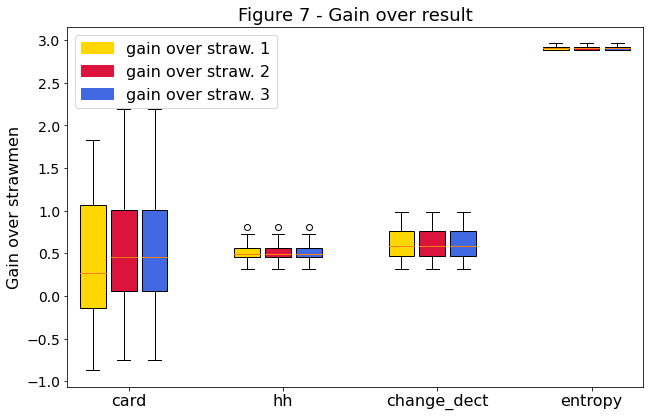

In [24]:
## comparison version plot
# box plot 
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# Box plots with custom fill colors
# https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

import matplotlib.patches as mpatches

# xlabels = ['Heavy Hitter', "Cardinality", "Entropy"]
xlabels = all_metrics
colors = ['gold', 'crimson', 'royalblue']
colors = colors * len(xlabels)

fig = plt.figure(figsize = (8, 5))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

plot_list = []
for m in all_metrics:
    plot_list.append(gain_result[m][0])
    plot_list.append(gain_result[m][1])
    plot_list.append(gain_result[m][2])

# Creating plot
bplot = ax.boxplot(x=plot_list, 
                   positions = get_x_position(len(all_metrics), len(gain_result[m])),
                   patch_artist=True)
# ax.set_xlim(0, 1)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# plt.title("Naive solutions comparison", fontsize=16)
plt.ylabel("Gain over strawmen", fontsize=16)
# plt.xlabel("Solution")
plt.xticks(get_xtick_position(len(all_metrics), len(gain_result[m])), xlabels, fontsize=16)
plt.yticks(fontsize=14)

plt.title("Figure 7 - Gain over result", fontsize=18)

# create legends
# xlabels = ['Best algorithms', "General algorithm"]
legend_patch = []
legend_patch.append(mpatches.Patch(color='gold', label='gain over straw. 1'))
legend_patch.append(mpatches.Patch(color='crimson', label='gain over straw. 2'))
legend_patch.append(mpatches.Patch(color='royalblue', label='gain over straw. 3'))
plt.legend(handles=legend_patch, fontsize=16)

# plt.savefig('test.png', format='png', bbox_inches='tight')
# plt.savefig('test.eps', format='eps', bbox_inches='tight')

# show plot
plt.show()

### Consolidate all metrics with gain over result

In [43]:
straws = ['straw. 1', 'straw. 2', 'straw. 3', ]
merge_gain_result = [[], [], []]

for m in all_metrics:
    merge_gain_result[0] = np.concatenate((merge_gain_result[0], gain_result[m][0]))
    merge_gain_result[1] = np.concatenate((merge_gain_result[1], gain_result[m][1]))
    merge_gain_result[2] = np.concatenate((merge_gain_result[2], gain_result[m][2]))

# print(len(merge_gain_result[0]))
# print(len(gain_result[m][0]))
# print(merge_gain_result)

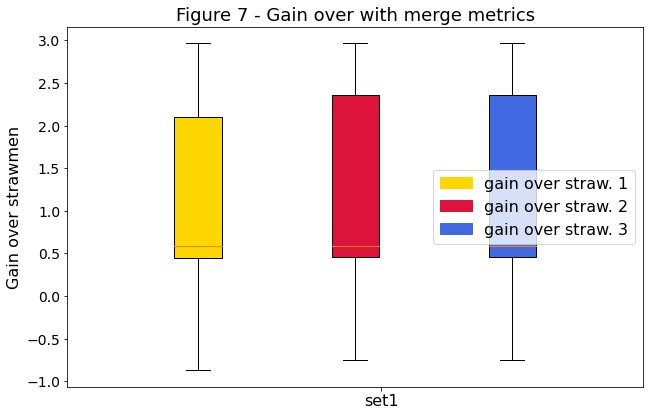

In [48]:
## comparison version plot
# box plot 
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# Box plots with custom fill colors
# https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

import matplotlib.patches as mpatches

# xlabels = ['Heavy Hitter', "Cardinality", "Entropy"]
xlabels = ['set1']
colors = ['gold', 'crimson', 'royalblue']
colors = colors * len(xlabels)

fig = plt.figure(figsize = (8, 5))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

plot_list = []
for d in merge_gain_result:
    plot_list.append(d)

# Creating plot
bplot = ax.boxplot(x=plot_list, 
                   positions = get_x_position(len(xlabels), len(merge_gain_result)),
                   patch_artist=True)
# ax.set_xlim(0, 1)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# plt.title("Naive solutions comparison", fontsize=16)
plt.ylabel("Gain over strawmen", fontsize=16)
# plt.xlabel("Solution")
plt.xticks(get_xtick_position(len(xlabels), len(merge_gain_result)), xlabels, fontsize=16)
plt.yticks(fontsize=14)

plt.title("Figure 7 - Gain over with merge metrics", fontsize=18)

# create legends
# xlabels = ['Best algorithms', "General algorithm"]
legend_patch = []
legend_patch.append(mpatches.Patch(color='gold', label='gain over straw. 1'))
legend_patch.append(mpatches.Patch(color='crimson', label='gain over straw. 2'))
legend_patch.append(mpatches.Patch(color='royalblue', label='gain over straw. 3'))
plt.legend(handles=legend_patch, fontsize=16)

# plt.savefig('test.png', format='png', bbox_inches='tight')
# plt.savefig('test.eps', format='eps', bbox_inches='tight')

# show plot
plt.show()